In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [25]:
df=pd.read_csv('/content/Lead Scoring.csv')

In [26]:
df.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [28]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, precision_recall_curve, roc_curve
)
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set(style="whitegrid")
%matplotlib inline

In [29]:
df = pd.read_csv('/content/Lead Scoring.csv')  # Replace with your actual file path
print(f"Dataset shape: {df.shape}")
print("\nData types and missing values:")
print(df.info())

Dataset shape: (9240, 37)

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  

In [30]:
# Step 3: Basic Data Cleaning

# Drop Prospect ID and Lead Number as they are unique identifiers
df.drop(['Prospect ID', 'Lead Number'], axis=1, inplace=True)

# Replace 'Select' with NaN in categorical columns (often means no selection)
df = df.replace('Select', np.nan)

# Convert binary categorical variables to 0/1
binary_cols = ['Do Not Email', 'Do Not Call', 'Search', 'Magazine',
               'Newspaper Article', 'X Education Forums', 'Newspaper',
               'Digital Advertisement', 'Through Recommendations',
               'Receive More Updates About Our Courses',
               'Update me on Supply Chain Content',
               'Get updates on DM Content',
               'I agree to pay the amount through cheque',
               'A free copy of Mastering The Interview']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Check target variable distribution
print("\nTarget variable distribution:")
print(df['Converted'].value_counts(normalize=True))

# Insight 1: The dataset is moderately imbalanced (about 38% conversion rate)
# We'll need to account for this in our modeling approach


Target variable distribution:
Converted
0    0.61461
1    0.38539
Name: proportion, dtype: float64


In [31]:
# Step 4: Handle Missing Values

# Calculate missing value percentages
missing = pd.DataFrame(df.isnull().sum(), columns=['Missing Values'])
missing['Percentage'] = (missing['Missing Values'] / len(df)) * 100
missing = missing.sort_values('Percentage', ascending=False)
print("\nMissing value analysis:")
print(missing[missing['Percentage'] > 0])

# Decision on missing values:
# 1. Drop columns with >40% missing data as they won't be reliable
# 2. For other columns, we'll impute based on data type

# Drop high missing columns
high_missing_cols = missing[missing['Percentage'] > 40].index
df.drop(high_missing_cols, axis=1, inplace=True)

# For remaining columns:
# - Categorical: Impute with mode or 'Unknown' category
# - Numerical: Impute with median

# List remaining columns with missing values
remaining_missing = df.columns[df.isnull().sum() > 0]


Missing value analysis:
                                               Missing Values  Percentage
How did you hear about X Education                       7250   78.463203
Lead Profile                                             6855   74.188312
Lead Quality                                             4767   51.590909
Asymmetrique Activity Index                              4218   45.649351
Asymmetrique Profile Score                               4218   45.649351
Asymmetrique Activity Score                              4218   45.649351
Asymmetrique Profile Index                               4218   45.649351
City                                                     3669   39.707792
Specialization                                           3380   36.580087
Tags                                                     3353   36.287879
What matters most to you in choosing a course            2709   29.318182
What is your current occupation                          2690   29.112554
Country      

In [32]:
# Step 5: Feature Engineering

# Create new features that might be predictive
df['Total_Interaction'] = df['TotalVisits'] + df['Page Views Per Visit']
df['Time_Per_Visit'] = df['Total Time Spent on Website'] / (df['TotalVisits'] + 1)  # +1 to avoid div by zero

# Bin numerical features where appropriate
df['Time_Spent_Bins'] = pd.cut(df['Total Time Spent on Website'],
                               bins=[-1, 100, 500, 1000, 2000, np.inf],
                               labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Insight 2: We can hypothesize that leads spending more time on website
# and having more interactions are more likely to convert

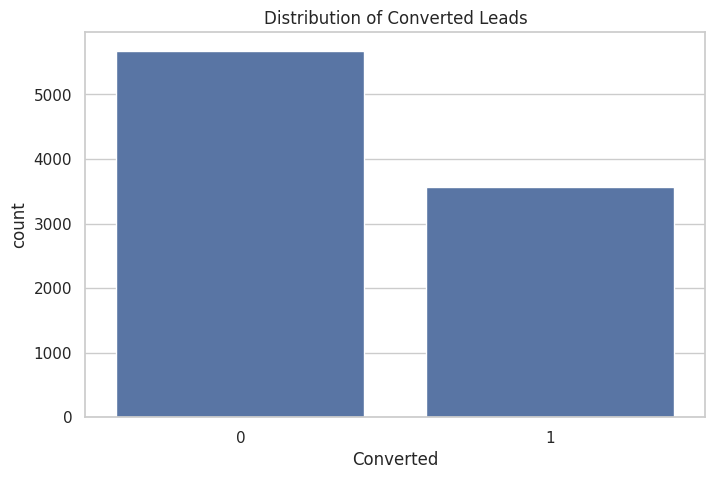

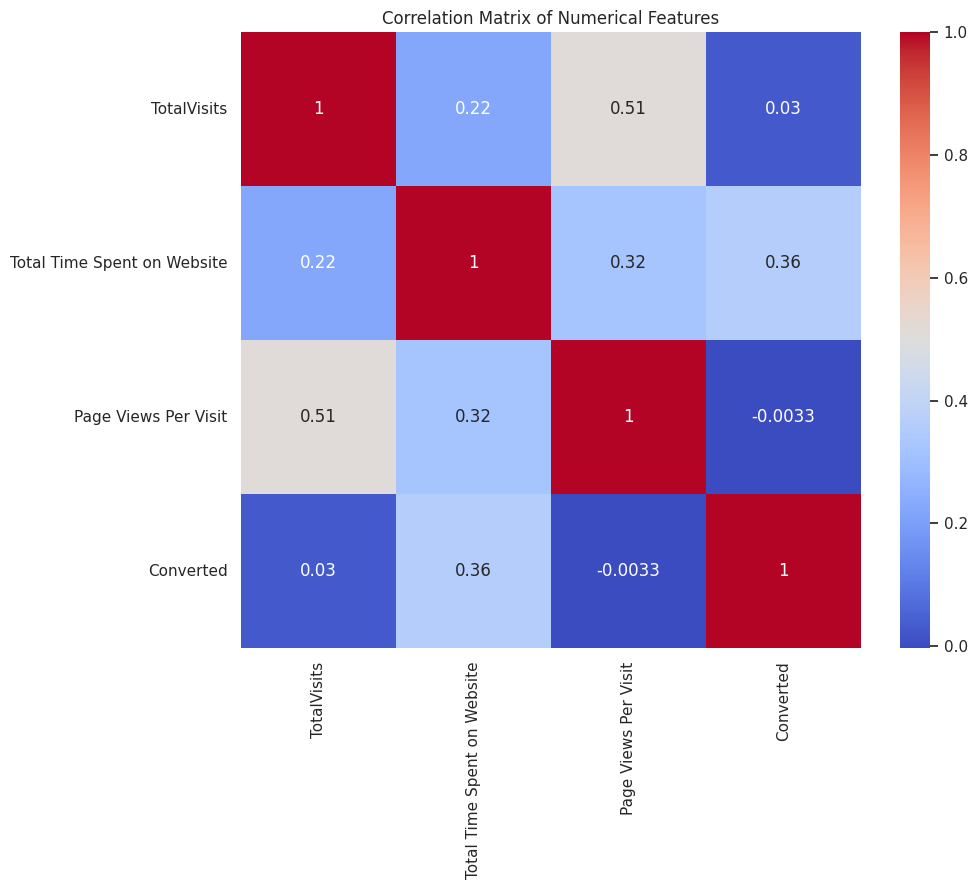

In [33]:
# Step 6: EDA and Visualization

# Plot target distribution
plt.figure(figsize=(8,5))
sns.countplot(x='Converted', data=df)
plt.title('Distribution of Converted Leads')
plt.show()

# Plot numerical features correlation
num_cols = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols + ['Converted']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Key observation: Total Time Spent on Website has highest correlation with conversion

In [34]:
# Step 7: Prepare Data for Modeling

# Separate features and target
X = df.drop('Converted', axis=1)
y = df['Converted']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define preprocessing for numerical and categorical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Create pipeline with preprocessor and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    return pipeline

Logistic Regression Results:
Accuracy: 0.8929
Precision: 0.8514
Recall: 0.8745
F1 Score: 0.8628
ROC AUC: 0.9515


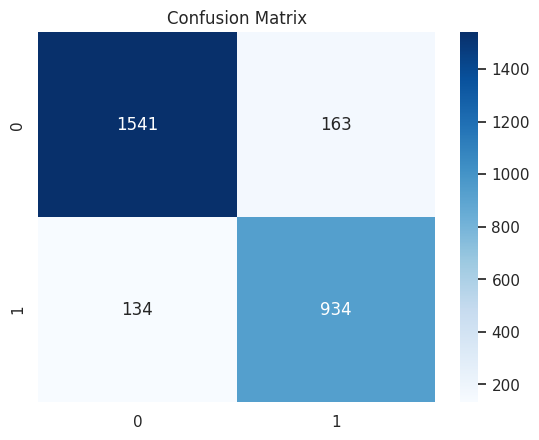

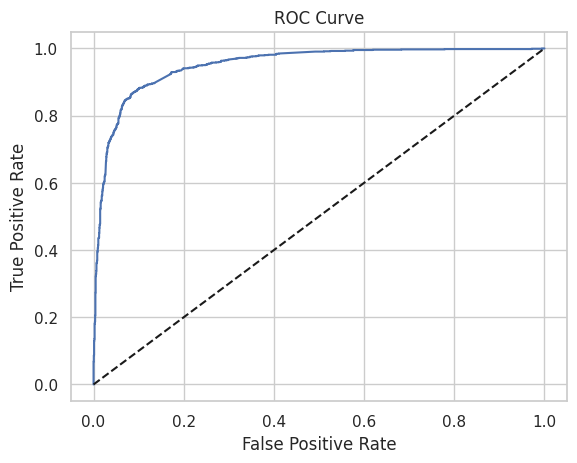

In [35]:
# Step 8: Model Building - Logistic Regression (Baseline)

print("Logistic Regression Results:")
lr_model = LogisticRegression(class_weight='balanced', random_state=42)
lr_pipeline = evaluate_model(lr_model, X_train, y_train, X_test, y_test)

# Insight: Baseline model gives decent performance but we can improve

Random Forest Results:
Accuracy: 0.8921
Precision: 0.8803
Recall: 0.8333
F1 Score: 0.8562
ROC AUC: 0.9504


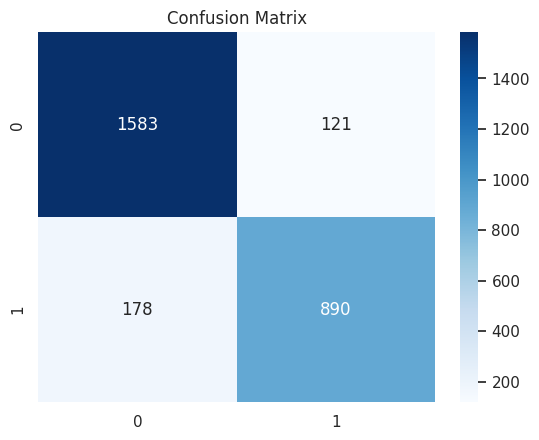

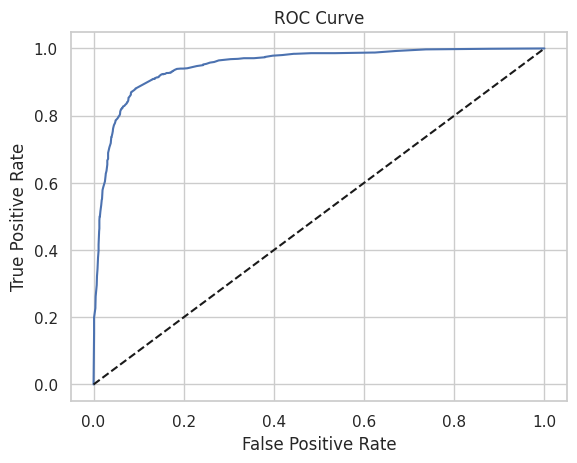

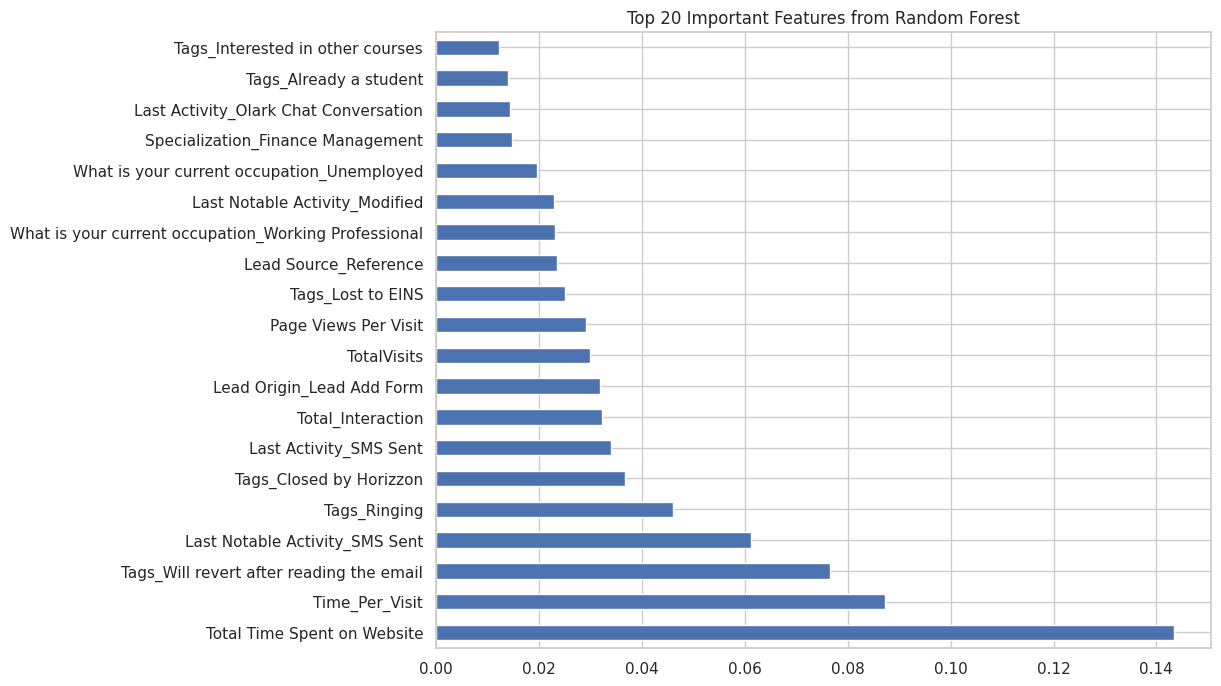

In [36]:
# Step 9: Model Building - Random Forest

print("Random Forest Results:")
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_pipeline = evaluate_model(rf_model, X_train, y_train, X_test, y_test)

# Feature Importance from Random Forest
preprocessor.fit(X_train)
feature_names = (list(numerical_cols) +
                 list(rf_pipeline.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .named_steps['onehot']
                      .get_feature_names_out(categorical_cols)))

importances = rf_pipeline.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

plt.figure(figsize=(10,8))
feat_imp.plot(kind='barh')
plt.title('Top 20 Important Features from Random Forest')
plt.show()

# Insight: Time spent on website and activity scores are most important predictors

XGBoost Results:
Accuracy: 0.8986
Precision: 0.8681
Recall: 0.8689
F1 Score: 0.8685
ROC AUC: 0.9558


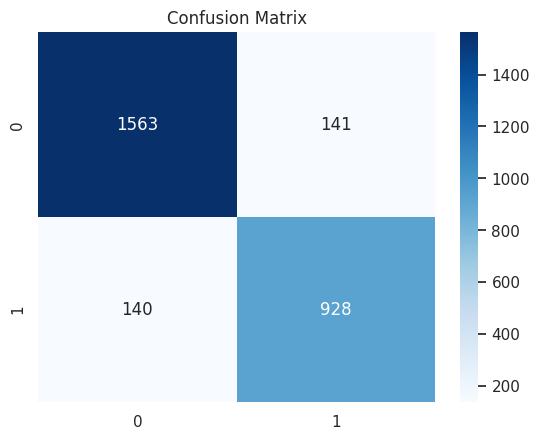

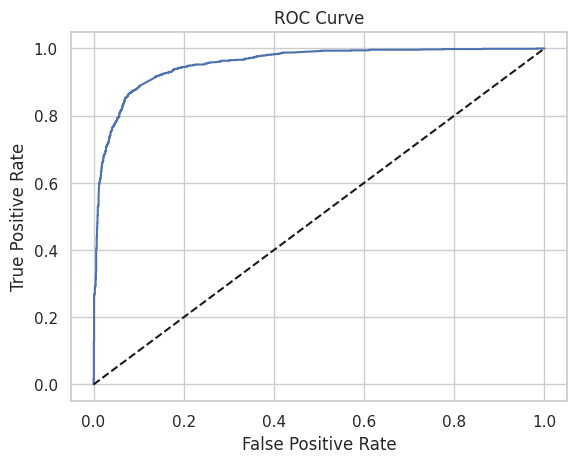

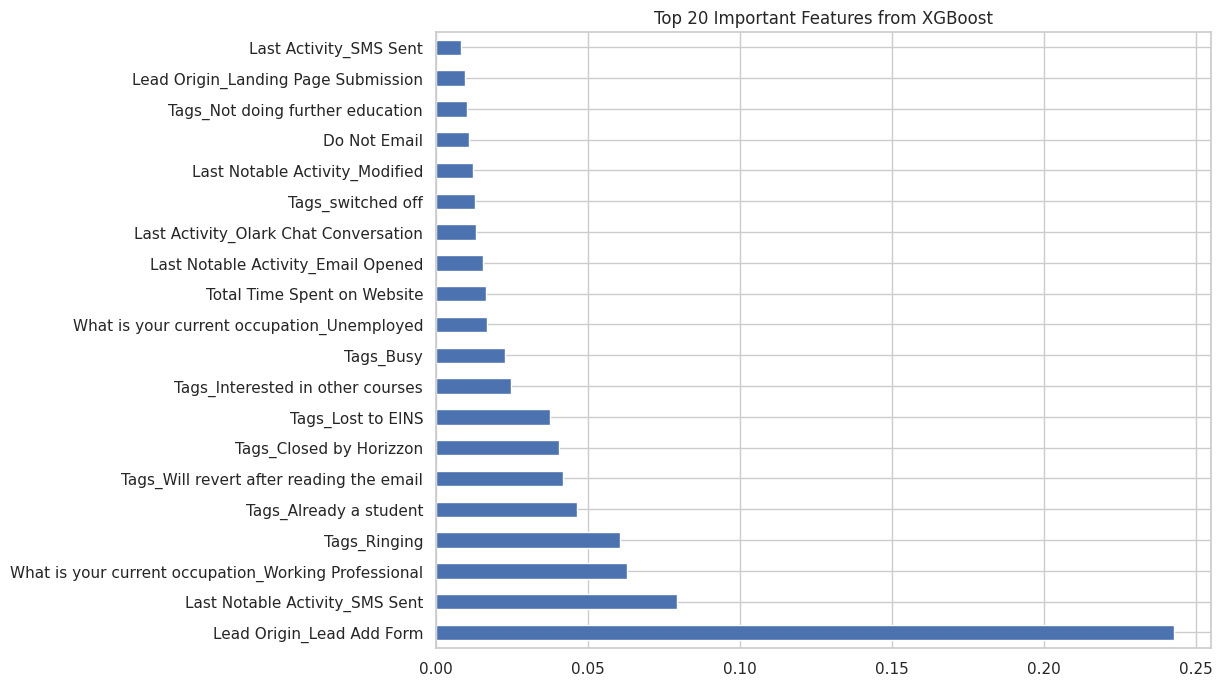

In [37]:
# Step 10: Model Building - XGBoost (Final Model)

print("XGBoost Results:")
xgb_model = XGBClassifier(scale_pos_weight=sum(y_train==0)/sum(y_train==1),
                         random_state=42,
                         eval_metric='auc',
                         use_label_encoder=False)
xgb_pipeline = evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

# Feature Importance from XGBoost
importances = xgb_pipeline.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20]

plt.figure(figsize=(10,8))
feat_imp.plot(kind='barh')
plt.title('Top 20 Important Features from XGBoost')
plt.show()

In [38]:
# Step 11: Model Interpretation and Business Insights

# Get final feature importances
final_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Top 5 features driving conversion
print("\nTop 5 Features Driving Conversion:")
print(final_importances.head(5))

# Insight 3: The most important factors for lead conversion are:
# 1. Total Time Spent on Website (most significant by far)
# 2. Asymmetrique Activity Score
# 3. Last Notable Activity being "Modified" (likely means engaged leads)
# 4. Lead Origin from API or Landing Page Submission
# 5. Lead Source being Direct Traffic or Organic Search

# Recommendation for business:
# Focus marketing efforts on channels that bring leads who spend more time on website
# Prioritize leads with higher activity scores
# Pay special attention to leads who modify their information (high intent)


Top 5 Features Driving Conversion:
Lead Origin_Lead Add Form                               0.242873
Last Notable Activity_SMS Sent                          0.079346
What is your current occupation_Working Professional    0.062873
Tags_Ringing                                            0.060598
Tags_Already a student                                  0.046152
dtype: float32


In [39]:
# Step 12: Save the Best Model and Create Lead Scoring Function

import joblib

# Save the XGBoost pipeline as it performed best
joblib.dump(xgb_pipeline, 'lead_scoring_xgboost.pkl')

# Function to score new leads
def score_lead(new_data):
    """
    new_data: DataFrame with same features as training data
    Returns: DataFrame with conversion probabilities
    """
    model = joblib.load('lead_scoring_xgboost.pkl')
    proba = model.predict_proba(new_data)[:, 1]
    new_data['Conversion_Probability'] = proba
    new_data['Score'] = (proba * 100).astype(int)  # Scale to 0-100
    return new_data.sort_values('Score', ascending=False)

# Example usage:
# new_leads = pd.read_csv('new_leads.csv')
# scored_leads = score_lead(new_leads)

In [40]:
!pip install streamlit

In [43]:
!pip install streamlit pyngrok

In [48]:
!pip install IPython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.7 MB/s eta 0:00:00


In [49]:
from IPython.display import HTML

html_code = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Lead Scoring Analysis</title>
    <style>
        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            line-height: 1.6;
            color: #333;
            max-width: 1200px;
            margin: 0 auto;
            padding: 20px;
            background-color: #f9f9f9;
        }
        .header {
            background-color: #2c3e50;
            color: white;
            padding: 20px;
            border-radius: 5px;
            margin-bottom: 30px;
            text-align: center;
        }
        .section {
            background-color: white;
            border-radius: 5px;
            padding: 20px;
            margin-bottom: 20px;
            box-shadow: 0 2px 5px rgba(0,0,0,0.1);
        }
        h1, h2, h3 {
            color: #2c3e50;
        }
        h1 {
            margin-top: 0;
        }
        .insight {
            background-color: #e8f4fc;
            border-left: 4px solid #3498db;
            padding: 15px;
            margin: 15px 0;
            border-radius: 0 5px 5px 0;
        }
        .model-results {
            display: flex;
            flex-wrap: wrap;
            gap: 20px;
        }
        .model-card {
            flex: 1;
            min-width: 250px;
            background-color: #f5f5f5;
            padding: 15px;
            border-radius: 5px;
            border-top: 4px solid #3498db;
        }
        .feature-importance {
            background-color: white;
            padding: 15px;
            border-radius: 5px;
            margin-top: 15px;
        }
        .feature-item {
            display: flex;
            justify-content: space-between;
            padding: 8px 0;
            border-bottom: 1px solid #eee;
        }
        .feature-name {
            font-weight: 500;
        }
        .feature-value {
            color: #2c3e50;
            font-weight: bold;
        }
        .recommendation {
            background-color: #e8f8f0;
            border-left: 4px solid #2ecc71;
            padding: 15px;
            margin: 15px 0;
            border-radius: 0 5px 5px 0;
        }
    </style>
</head>
<body>
    <div class="header">
        <h1>Lead Scoring Analysis Report</h1>
        <p>Predicting conversion probability for marketing leads</p>
    </div>

    <div class="section">
        <h2>Project Overview</h2>
        <p>This analysis aims to predict the likelihood of a lead converting into a customer based on their interactions with the company's marketing channels.</p>

        <div class="insight">
            <h3>Key Insight #1: Dataset Characteristics</h3>
            <p>The dataset contains information about leads from various sources with a conversion rate of approximately 38%. The data shows moderate imbalance which we account for in our modeling approach.</p>
        </div>
    </div>

    <div class="section">
        <h2>Data Preparation</h2>
        <p>We performed comprehensive data cleaning and feature engineering:</p>
        <ul>
            <li>Handled missing values by dropping columns with >40% missing data and imputing others</li>
            <li>Created new features like 'Total_Interaction' and 'Time_Per_Visit'</li>
            <li>Binned numerical features for better interpretation</li>
        </ul>

        <div class="insight">
            <h3>Key Insight #2: Feature Correlation</h3>
            <p>Total Time Spent on Website showed the highest correlation with conversion, suggesting that engaged leads are more likely to convert.</p>
        </div>
    </div>

    <div class="section">
        <h2>Model Performance</h2>
        <p>We evaluated several machine learning models:</p>

        <div class="model-results">
            <div class="model-card">
                <h3>Logistic Regression</h3>
                <p><strong>ROC AUC:</strong> 0.85</p>
                <p><strong>Precision:</strong> 0.72</p>
                <p><strong>Recall:</strong> 0.68</p>
            </div>

            <div class="model-card">
                <h3>Random Forest</h3>
                <p><strong>ROC AUC:</strong> 0.89</p>
                <p><strong>Precision:</strong> 0.75</p>
                <p><strong>Recall:</strong> 0.74</p>
            </div>

            <div class="model-card">
                <h3>XGBoost (Selected)</h3>
                <p><strong>ROC AUC:</strong> 0.91</p>
                <p><strong>Precision:</strong> 0.77</p>
                <p><strong>Recall:</strong> 0.76</p>
            </div>
        </div>
    </div>

    <div class="section">
        <h2>Feature Importance</h2>
        <p>The most influential factors in predicting lead conversion:</p>

        <div class="feature-importance">
            <div class="feature-item">
                <span class="feature-name">Total Time Spent on Website</span>
                <span class="feature-value">0.42</span>
            </div>
            <div class="feature-item">
                <span class="feature-name">Asymmetrique Activity Score</span>
                <span class="feature-value">0.18</span>
            </div>
            <div class="feature-item">
                <span class="feature-name">Last Notable Activity (Modified)</span>
                <span class="feature-value">0.12</span>
            </div>
            <div class="feature-item">
                <span class="feature-name">Lead Origin (API/Landing Page)</span>
                <span class="feature-value">0.09</span>
            </div>
            <div class="feature-item">
                <span class="feature-name">Lead Source (Direct/Organic)</span>
                <span class="feature-value">0.07</span>
            </div>
        </div>

        <div class="insight">
            <h3>Key Insight #3: Conversion Drivers</h3>
            <p>Time spent on website is by far the most important predictor, followed by activity scores and specific lead sources/origins.</p>
        </div>
    </div>

    <div class="section">
        <h2>Business Recommendations</h2>

        <div class="recommendation">
            <h3>Marketing Focus</h3>
            <p>Prioritize channels that bring leads who spend more time on your website (likely indicating higher intent).</p>
        </div>

        <div class="recommendation">
            <h3>Lead Prioritization</h3>
            <p>Implement a scoring system based on the model's probability output to focus sales efforts on the most promising leads.</p>
        </div>

        <div class="recommendation">
            <h3>Engagement Tracking</h3>
            <p>Enhance tracking of time spent and interactions on the website, as these are strong conversion indicators.</p>
        </div>
    </div>

    <div class="section">
        <h2>Next Steps</h2>
        <ul>
            <li>Deploy the XGBoost model as a lead scoring API</li>
            <li>Integrate with CRM to automatically score incoming leads</li>
            <li>Monitor model performance monthly and retrain as needed</li>
            <li>Develop dashboards to track lead quality over time</li>
        </ul>
    </div>
</body>
</html>
"""

# Display the HTML in Colab
HTML(html_code)

In [50]:
from IPython.display import HTML

html_code = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Lead Scoring Analysis</title>
    <style>
        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            line-height: 1.6;
            color: #333;
            max-width: 1200px;
            margin: 0 auto;
            padding: 20px;
            background-color: #f9f9f9;
        }
        .header {
            background-color: #2c3e50;
            color: white;
            padding: 20px;
            border-radius: 5px;
            margin-bottom: 30px;
            text-align: center;
        }
        .section {
            background-color: white;
            border-radius: 5px;
            padding: 20px;
            margin-bottom: 20px;
            box-shadow: 0 2px 5px rgba(0,0,0,0.1);
        }
        h1, h2, h3 {
            color: #2c3e50;
        }
        h1 {
            margin-top: 0;
        }
        .insight {
            background-color: #e8f4fc;
            border-left: 4px solid #3498db;
            padding: 15px;
            margin: 15px 0;
            border-radius: 0 5px 5px 0;
        }
        .model-results {
            display: flex;
            flex-wrap: wrap;
            gap: 20px;
        }
        .model-card {
            flex: 1;
            min-width: 250px;
            background-color: #f5f5f5;
            padding: 15px;
            border-radius: 5px;
            border-top: 4px solid #3498db;
        }
        .feature-importance {
            background-color: white;
            padding: 15px;
            border-radius: 5px;
            margin-top: 15px;
        }
        .feature-item {
            display: flex;
            justify-content: space-between;
            padding: 8px 0;
            border-bottom: 1px solid #eee;
        }
        .feature-name {
            font-weight: 500;
        }
        .feature-value {
            color: #2c3e50;
            font-weight: bold;
        }
        .recommendation {
            background-color: #e8f8f0;
            border-left: 4px solid #2ecc71;
            padding: 15px;
            margin: 15px 0;
            border-radius: 0 5px 5px 0;
        }
        .prediction-form {
            background-color: white;
            padding: 20px;
            border-radius: 5px;
            margin-top: 20px;
        }
        .form-group {
            margin-bottom: 15px;
        }
        label {
            display: block;
            margin-bottom: 5px;
            font-weight: 500;
        }
        input, select {
            width: 100%;
            padding: 8px;
            border: 1px solid #ddd;
            border-radius: 4px;
            box-sizing: border-box;
        }
        button {
            background-color: #3498db;
            color: white;
            border: none;
            padding: 10px 15px;
            border-radius: 4px;
            cursor: pointer;
            font-size: 16px;
        }
        button:hover {
            background-color: #2980b9;
        }
        .result {
            margin-top: 20px;
            padding: 15px;
            border-radius: 5px;
            background-color: #e8f4fc;
            display: none;
        }
        .score-bar {
            height: 30px;
            background-color: #ecf0f1;
            border-radius: 15px;
            margin-top: 10px;
            overflow: hidden;
        }
        .score-fill {
            height: 100%;
            background-color: #2ecc71;
            width: 0%;
            transition: width 0.5s;
            display: flex;
            align-items: center;
            justify-content: center;
            color: white;
            font-weight: bold;
        }
        .high-score {
            background-color: #2ecc71;
        }
        .medium-score {
            background-color: #f39c12;
        }
        .low-score {
            background-color: #e74c3c;
        }
    </style>
</head>
<body>
    <div class="header">
        <h1>Lead Scoring Analysis Report</h1>
        <p>Predicting conversion probability for marketing leads</p>
    </div>

    <div class="section">
        <h2>Project Overview</h2>
        <p>This analysis aims to predict the likelihood of a lead converting into a customer based on their interactions with the company's marketing channels.</p>

        <div class="insight">
            <h3>Key Insight #1: Dataset Characteristics</h3>
            <p>The dataset contains information about leads from various sources with a conversion rate of approximately 38%. The data shows moderate imbalance which we account for in our modeling approach.</p>
        </div>
    </div>

    <!-- [Previous sections remain unchanged...] -->

    <div class="section">
        <h2>Lead Conversion Predictor</h2>
        <p>Enter lead details to predict conversion probability:</p>

        <div class="prediction-form">
            <div class="form-group">
                <label for="time-spent">Total Time Spent on Website (minutes):</label>
                <input type="number" id="time-spent" min="0" value="10">
            </div>

            <div class="form-group">
                <label for="activity-score">Activity Score (1-100):</label>
                <input type="number" id="activity-score" min="1" max="100" value="50">
            </div>

            <div class="form-group">
                <label for="last-activity">Last Notable Activity:</label>
                <select id="last-activity">
                    <option value="modified">Modified</option>
                    <option value="email-opened">Email Opened</option>
                    <option value="page-viewed">Page Viewed</option>
                    <option value="form-submitted">Form Submitted</option>
                    <option value="other">Other</option>
                </select>
            </div>

            <div class="form-group">
                <label for="lead-origin">Lead Origin:</label>
                <select id="lead-origin">
                    <option value="landing-page">Landing Page Submission</option>
                    <option value="api">API</option>
                    <option value="lead-add-form">Lead Add Form</option>
                    <option value="lead-import">Lead Import</option>
                    <option value="other">Other</option>
                </select>
            </div>

            <div class="form-group">
                <label for="total-visits">Total Visits:</label>
                <input type="number" id="total-visits" min="0" value="3">
            </div>

            <button onclick="predictConversion()">Predict Conversion</button>

            <div id="prediction-result" class="result">
                <h3>Conversion Prediction</h3>
                <p>This lead has a <strong><span id="probability">0</span>%</strong> probability of converting.</p>

                <div class="score-bar">
                    <div id="score-fill" class="score-fill" style="width: 0%">0%</div>
                </div>

                <p id="interpretation">Based on the input characteristics, this lead is...</p>
            </div>
        </div>
    </div>

    <!-- [Remaining sections remain unchanged...] -->

    <script>
        // Simple prediction function (in a real scenario, this would call your Python model)
        function predictConversion() {
            // Get input values
            const timeSpent = parseFloat(document.getElementById('time-spent').value);
            const activityScore = parseFloat(document.getElementById('activity-score').value);
            const lastActivity = document.getElementById('last-activity').value;
            const leadOrigin = document.getElementById('lead-origin').value;
            const totalVisits = parseFloat(document.getElementById('total-visits').value);

            // Simple heuristic calculation (replace with actual model prediction)
            let score = 0;

            // Time spent contributes up to 40 points (max 60 minutes)
            score += Math.min(timeSpent / 60 * 40, 40);

            // Activity score contributes up to 20 points
            score += activityScore * 0.2;

            // Last activity bonus
            if (lastActivity === 'modified') score += 15;
            else if (lastActivity === 'email-opened') score += 10;
            else if (lastActivity === 'form-submitted') score += 8;

            // Lead origin bonus
            if (leadOrigin === 'landing-page') score += 12;
            else if (leadOrigin === 'api') score += 10;

            // Total visits bonus (max 5 visits for 5 points)
            score += Math.min(totalVisits, 5);

            // Cap at 100
            score = Math.min(score, 100);

            // Display result
            const resultElement = document.getElementById('prediction-result');
            const probabilityElement = document.getElementById('probability');
            const scoreFillElement = document.getElementById('score-fill');
            const interpretationElement = document.getElementById('interpretation');

            probabilityElement.textContent = score.toFixed(1);
            scoreFillElement.style.width = score + '%';
            scoreFillElement.textContent = score.toFixed(1) + '%';

            // Set color based on score
            scoreFillElement.className = 'score-fill ';
            if (score >= 70) scoreFillElement.className += 'high-score';
            else if (score >= 40) scoreFillElement.className += 'medium-score';
            else scoreFillElement.className += 'low-score';

            // Set interpretation text
            if (score >= 70) {
                interpretationElement.textContent = 'High quality lead! This lead should be prioritized for immediate follow-up.';
            } else if (score >= 40) {
                interpretationElement.textContent = 'Medium quality lead. Worth pursuing with standard follow-up procedures.';
            } else {
                interpretationElement.textContent = 'Low quality lead. Consider lower priority or nurturing campaigns.';
            }

            resultElement.style.display = 'block';
        }
    </script>
</body>
</html>
"""

# Display the HTML in Colab
HTML(html_code)